# ArmoniK architecture

## Requierement
    
the only requirement to use this notebookd is to install the python package [Diagrams](https://diagrams.mingrammer.com/) python package to run this jupyter notebook
    
```bash
pip install diagrams
```

## Optional

It can be difficult to visualize the change between two versions of the diagrams since it is a notebook. It is possible to alleviate that by using the python package: [ndime](https://diagrams.mingrammer.com/) 

```bash
 pip install nbdime --upgrade
```

# Diagram architecture ArmoniK

In [1]:
from diagrams import Cluster, Diagram, Edge, Node

from diagrams.onprem.database import MongoDB, Couchbase
from diagrams.onprem.inmemory import Redis
from diagrams.onprem.queue import RabbitMQ
from diagrams.onprem.container import K3S
from diagrams.onprem.iac import Terraform
from diagrams.onprem.monitoring import Grafana
from diagrams.onprem.monitoring import Prometheus
from diagrams.onprem.queue import Activemq
from diagrams.onprem.logging import Fluentbit
from diagrams.onprem.compute import Server
from diagrams.onprem.client import Client
from diagrams.onprem.monitoring import Prometheus

from diagrams.k8s.infra import Master, Node
from diagrams.k8s.clusterconfig import HPA 
from diagrams.k8s.compute import Pod, ReplicaSet
from diagrams.k8s.network import Ingress
from diagrams.k8s.group import Namespace
from diagrams.k8s.controlplane import API

from diagrams.programming.language import Cpp, Java, Python, Csharp
from diagrams.programming.framework import Angular

from diagrams.custom import Custom

from diagrams.elastic.saas import Elastic

from diagrams.aws.storage import S3
from diagrams.aws.storage import Storage
from diagrams.aws.storage import SimpleStorageServiceS3Bucket as S3Bucket
from diagrams.aws.database import Elasticache

from diagrams.oci.compute import Container

from urllib.request import urlretrieve

kube_url = "https://upload.wikimedia.org/wikipedia/labs/thumb/b/ba/Kubernetes-icon-color.svg/495px-Kubernetes-icon-color.svg.png"
kube_icon = "495px-Kubernetes-icon-color.svg.png"
urlretrieve(kube_url, kube_icon)

grpc_url = "https://cncf-branding.netlify.app/img/projects/grpc/icon/color/grpc-icon-color.png"
grpc_icon = "grpc-icon-color.png"
urlretrieve(grpc_url, grpc_icon)

keda_url = "https://cncf-branding.netlify.app/img/projects/keda/icon/color/keda-icon-color.png"
keda_icon = "keda-icon-color.png"
urlretrieve(keda_url, keda_icon)

seq_url = "https://blog.datalust.co/content/images/2018/09/Seq-380px-1.png"
seq_icon = "seq-icon.png"
urlretrieve(seq_url, seq_icon)

zip_url = "https://cdn-icons-png.flaticon.com/512/28/28814.png"
zip_icon = "zip-_icon.png"
urlretrieve(zip_url, zip_icon)

metrics_server_url = "https://api.civo.com/k3s-marketplace/metrics-server.png"
metrics_server_icon = "metrics-server-icon.png"
urlretrieve(metrics_server_url, metrics_server_icon)


computer_url = "https://cdn-icons-png.flaticon.com/512/22/22938.png"
computer_icon = "22938.png"
urlretrieve(computer_url, computer_icon)


Queue = Activemq
Inmem_storage = Redis #Elasticache
State_db = MongoDB
Cache = Couchbase
Bucket = Storage
Logs = Elastic
Armonik_Extension = Csharp

graph_attr = {
    "layout":"dot",
    "compound":"true",
    }

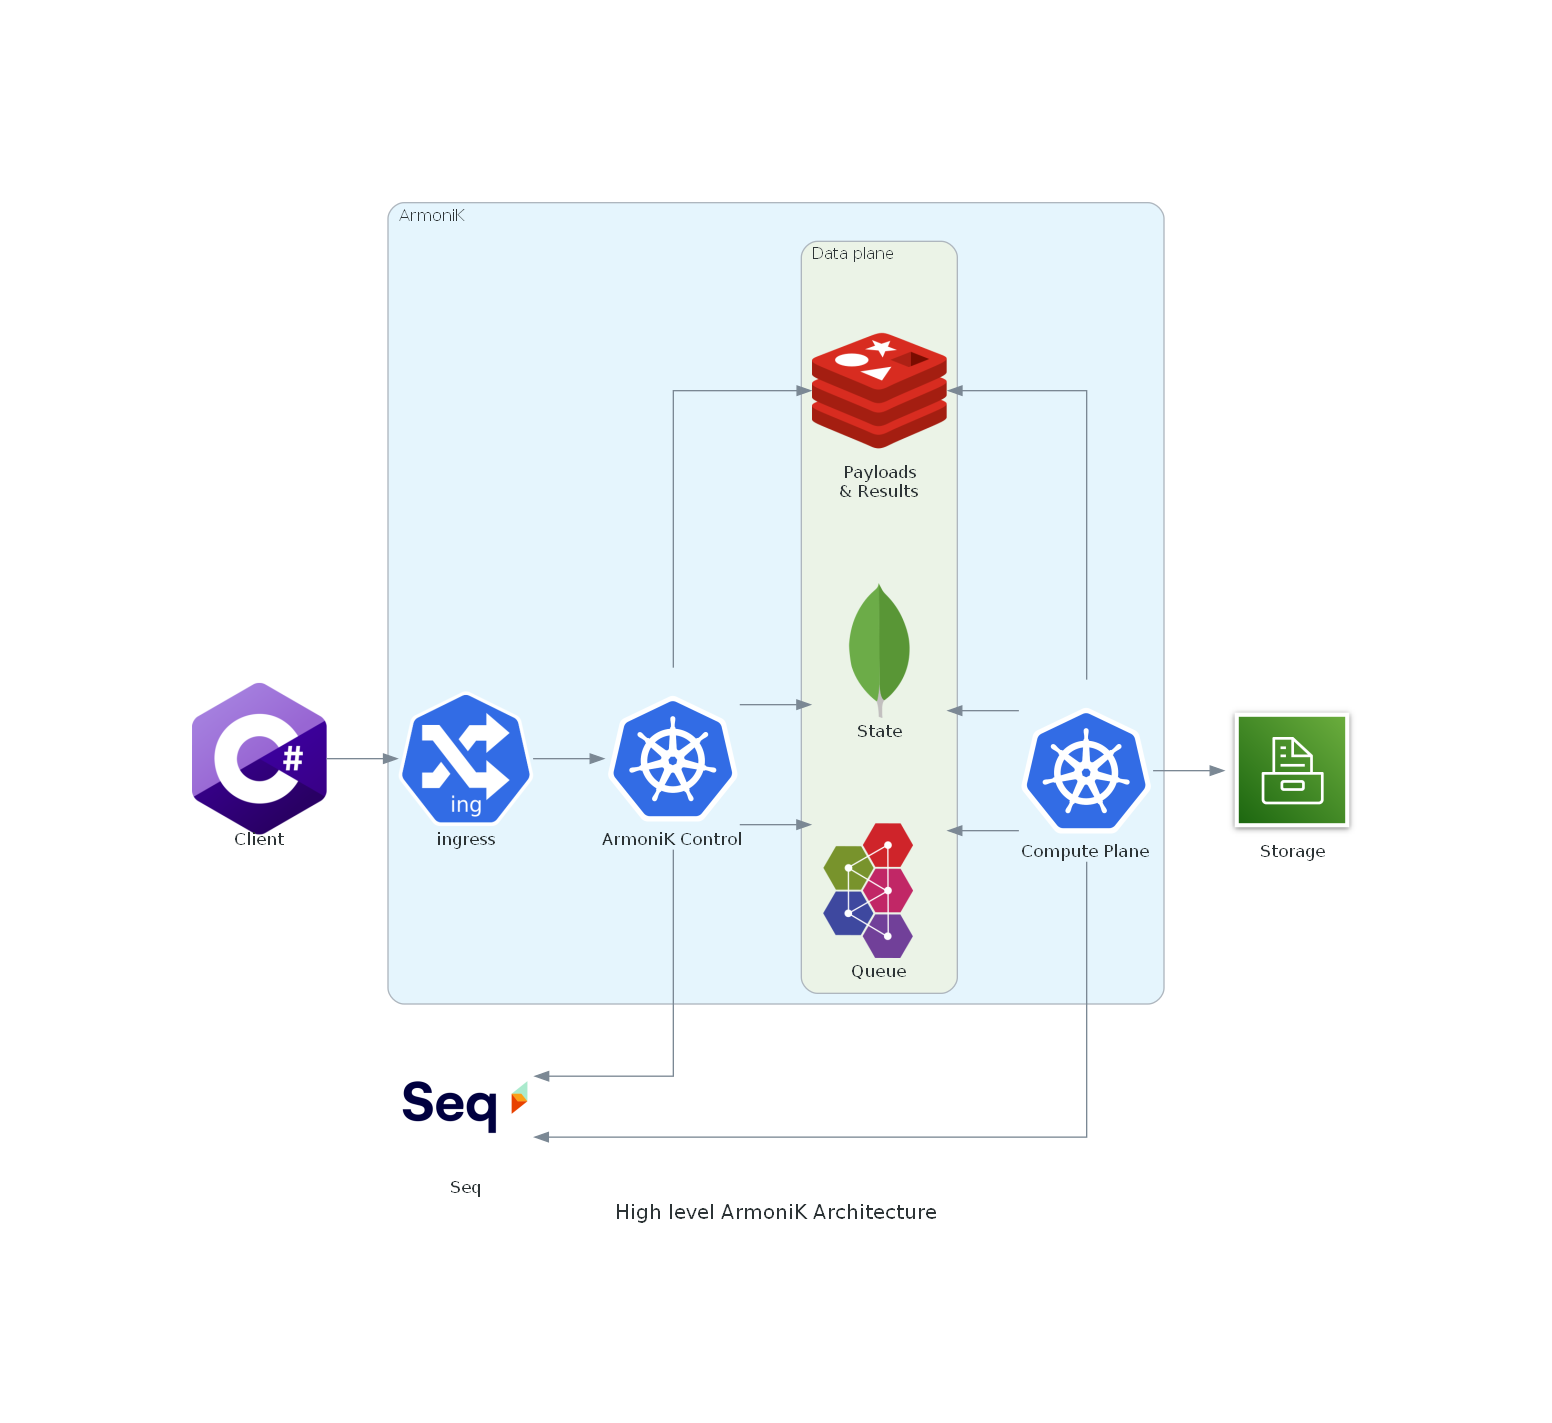

In [2]:
with Diagram("High level ArmoniK Architecture", show=False, outformat="png", graph_attr=graph_attr) as diag:
    
    client = Csharp("Client")
    logs =  Custom("Seq", seq_icon)
    storage = Bucket("Storage")
    
    with Cluster("ArmoniK"):
        compute_plane = Custom("Compute Plane", kube_icon)    
        ingress = Ingress("ingress")
        control = Custom("ArmoniK Control", kube_icon)
        
        with Cluster("Data plane"):
            payload = Inmem_storage("Payloads\n& Results")
            db = State_db("State") 
            queue = Queue("Queue")

    client >> ingress >> control
    control >> [payload, db, queue]
    [db, queue, payload]  << compute_plane >> storage
    logs << [control, compute_plane]
    
diag

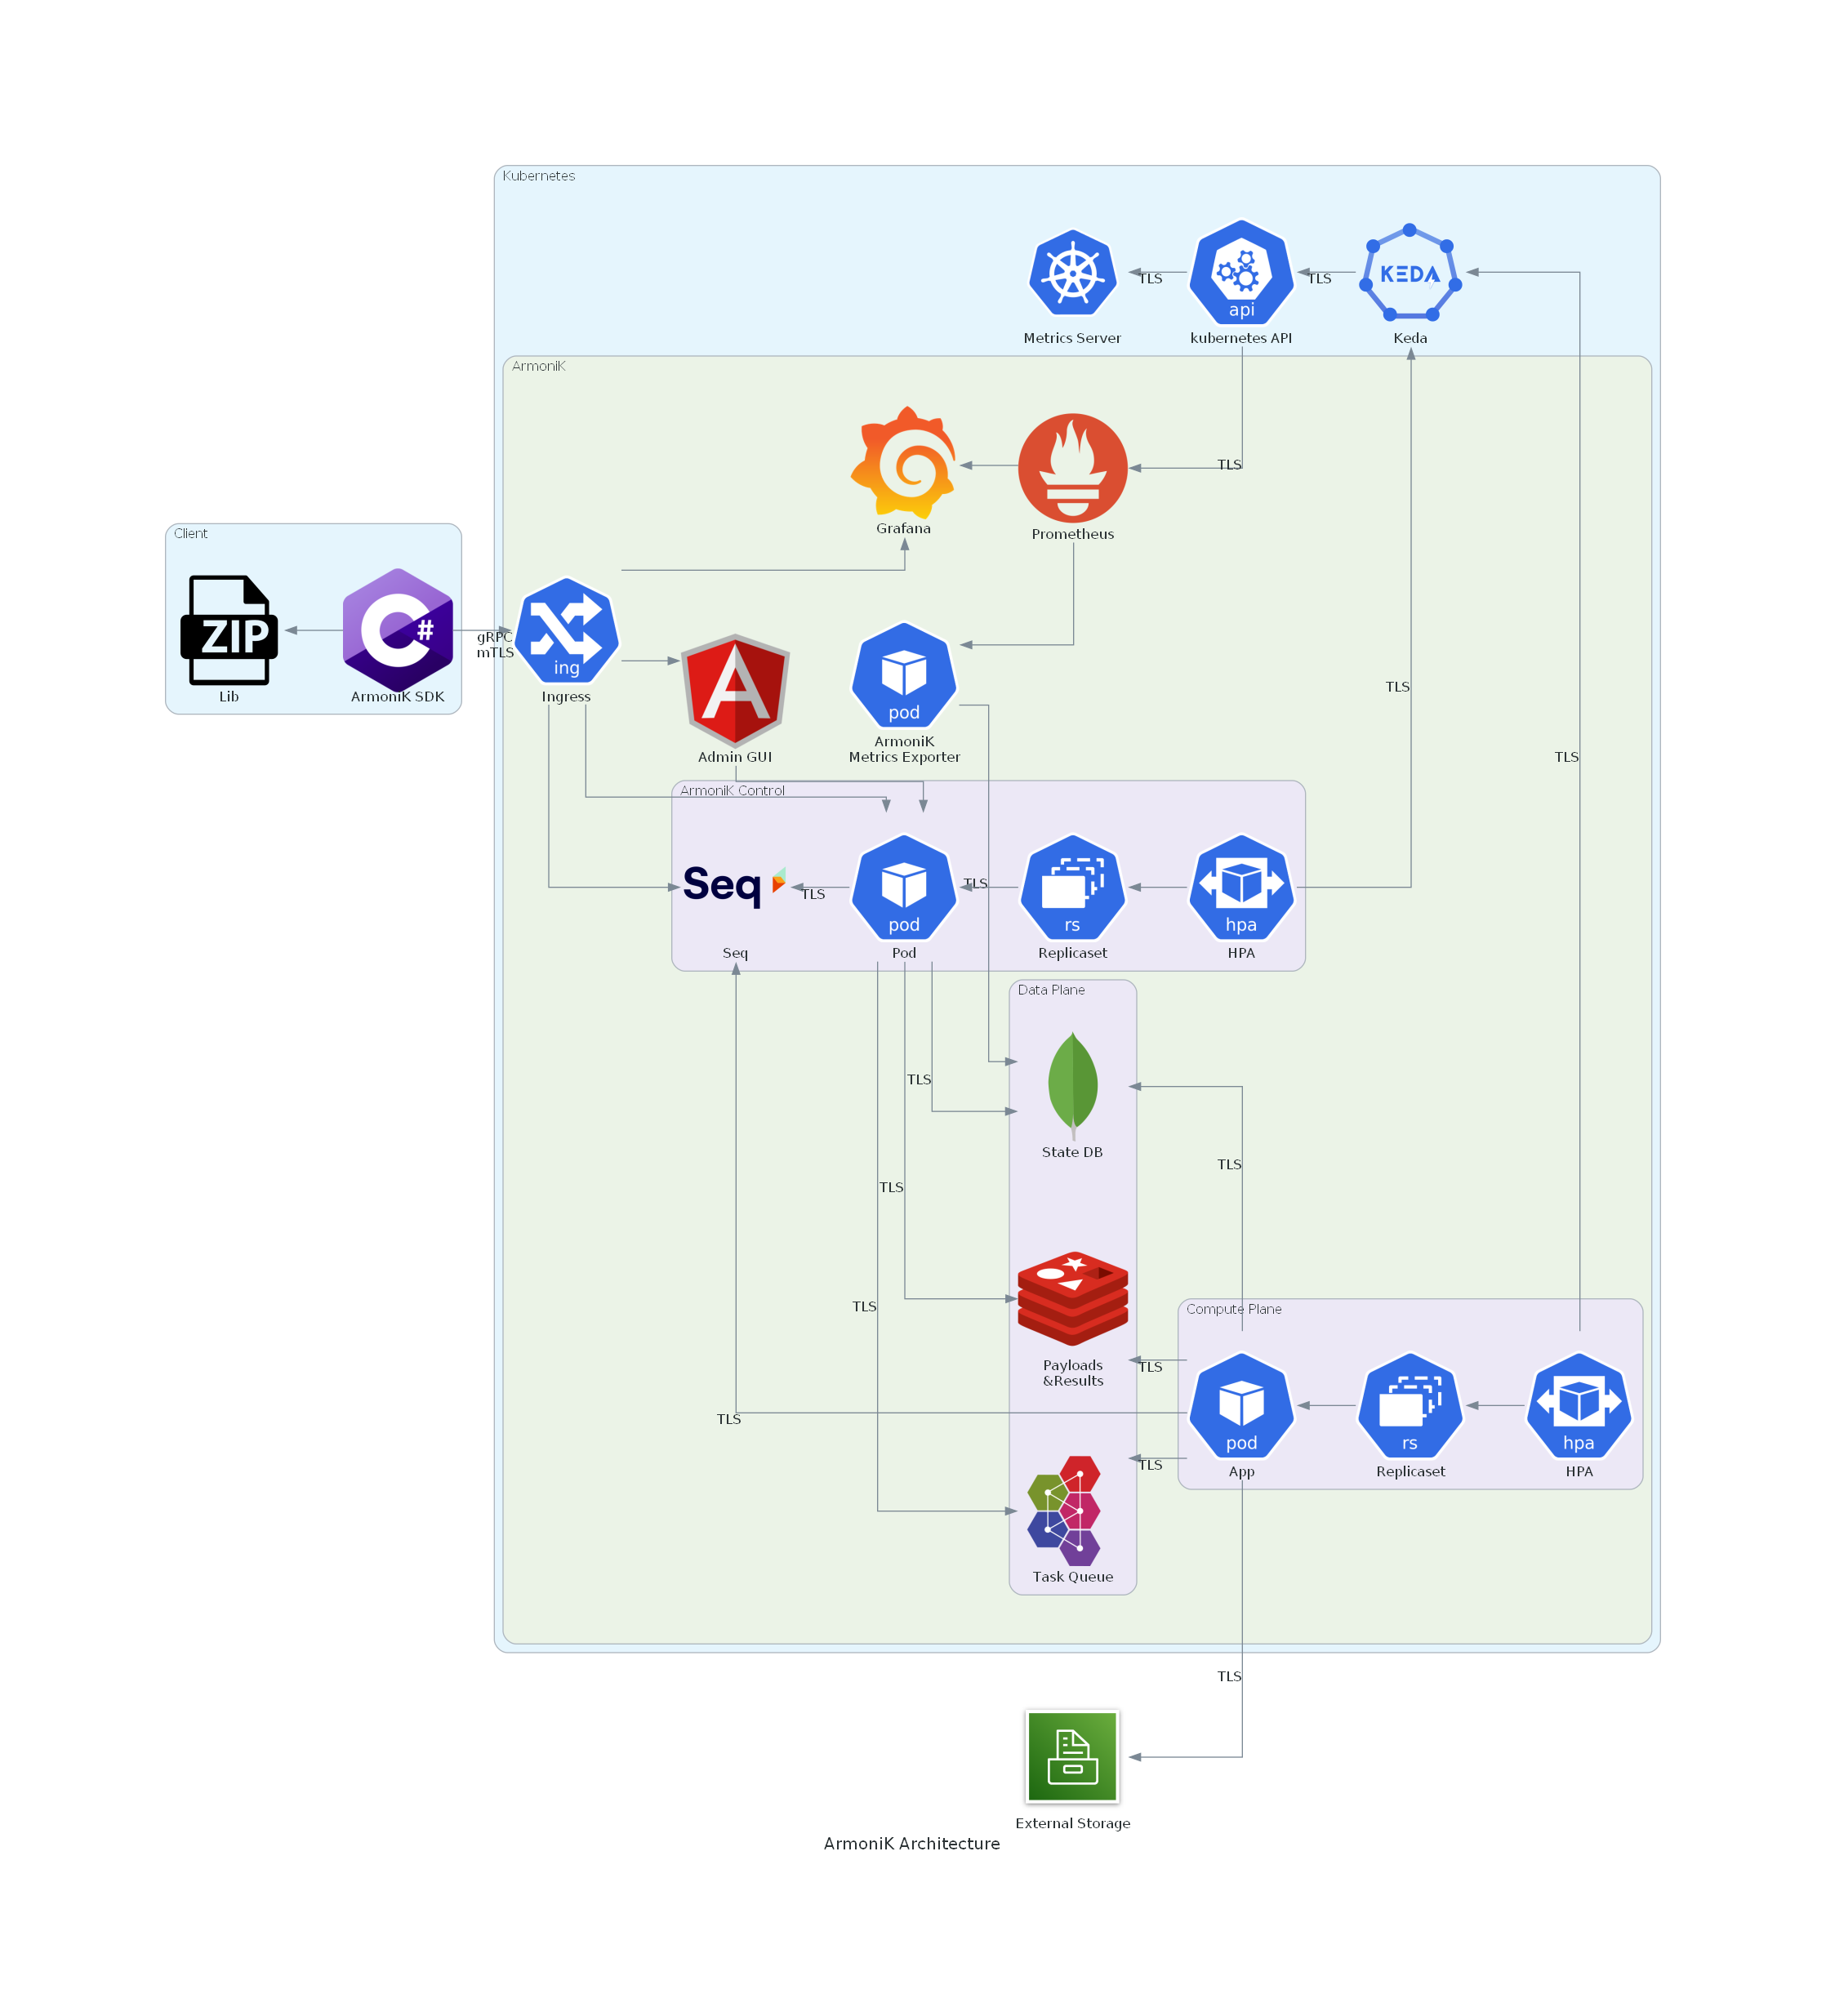

In [3]:
with Diagram("ArmoniK Architecture", show=False,  outformat="png", graph_attr=graph_attr) as diag:
 
    with Cluster("Kubernetes"):
        keda = Custom("Keda", keda_icon)
        kube_api = API("kubernetes API")        
        metrics_server = Custom("Metrics Server", metrics_server_icon)

        with Cluster("ArmoniK"):
            
            with Cluster("Data Plane"):
                inner_storage = Inmem_storage("Payloads\n&Results")
                task_queue = Queue("Task Queue")    
                state_db = State_db("State DB")
              
            
            metrics_viz = Grafana("Grafana")
            time_series_db = Prometheus("Prometheus")


            admin_gui = Angular("Admin GUI")
            metrics = Pod("ArmoniK\nMetrics Exporter")
            middleware = [metrics]

            ingress = Ingress("Ingress")

            with Cluster("ArmoniK Control"):
                hpa_replicaset_sub = HPA("HPA")
                replicaset_sub = ReplicaSet("Replicaset")
                submitter = Pod("Pod")

                logs =  Custom("Seq", seq_icon)

            with Cluster("Compute Plane"):
                hpa_replicaset = HPA("HPA")
                replicaset = ReplicaSet("Replicaset")
                pod_compute = Pod("App")
    
    with Cluster("Client"):
            app = Custom("Lib", zip_icon)
            sdk = Armonik_Extension("ArmoniK SDK")

    bucket = Bucket("External Storage")
    
    
    
    submitter  << replicaset_sub << hpa_replicaset_sub    
    pod_compute  << replicaset << hpa_replicaset
    #pod_compute >>  Edge(xlabel="TLS") >> bucket
    bucket << Edge(xlabel="TLS") << pod_compute 
                
    ingress >> [submitter, admin_gui, logs, metrics_viz]

    metrics_viz << time_series_db 
    admin_gui >> submitter
    #admin_gui >> Edge(xlabel="TLS") >> logs 
    submitter >>  Edge(xlabel="TLS") >> [inner_storage, 
                  task_queue, 
                  state_db]
    metrics >>  Edge(xlabel="TLS") >> state_db

    [inner_storage, 
     task_queue,
     state_db] << Edge(xlabel="TLS") << pod_compute     
     
    app << sdk 
    sdk >> Edge(xlabel="gRPC\nmTLS") >> [ingress]
    [sdk, pod_compute] >> Edge(xlabel="TLS") 
    
    logs << Edge(xlabel="TLS") << [pod_compute, submitter] 
    #hpa_replicaset >> Edge(xlabel="TLS") >> kube_api 
    keda << Edge(xlabel="TLS") << [hpa_replicaset, hpa_replicaset_sub] 
    
    
    kube_api << Edge(xlabel="TLS") << keda
    #keda >> Edge(label="TLS") >>  time_series_db >> metrics
     
    [time_series_db, metrics_server] << Edge(xlabel="TLS") << kube_api
    metrics << time_series_db
    
diag

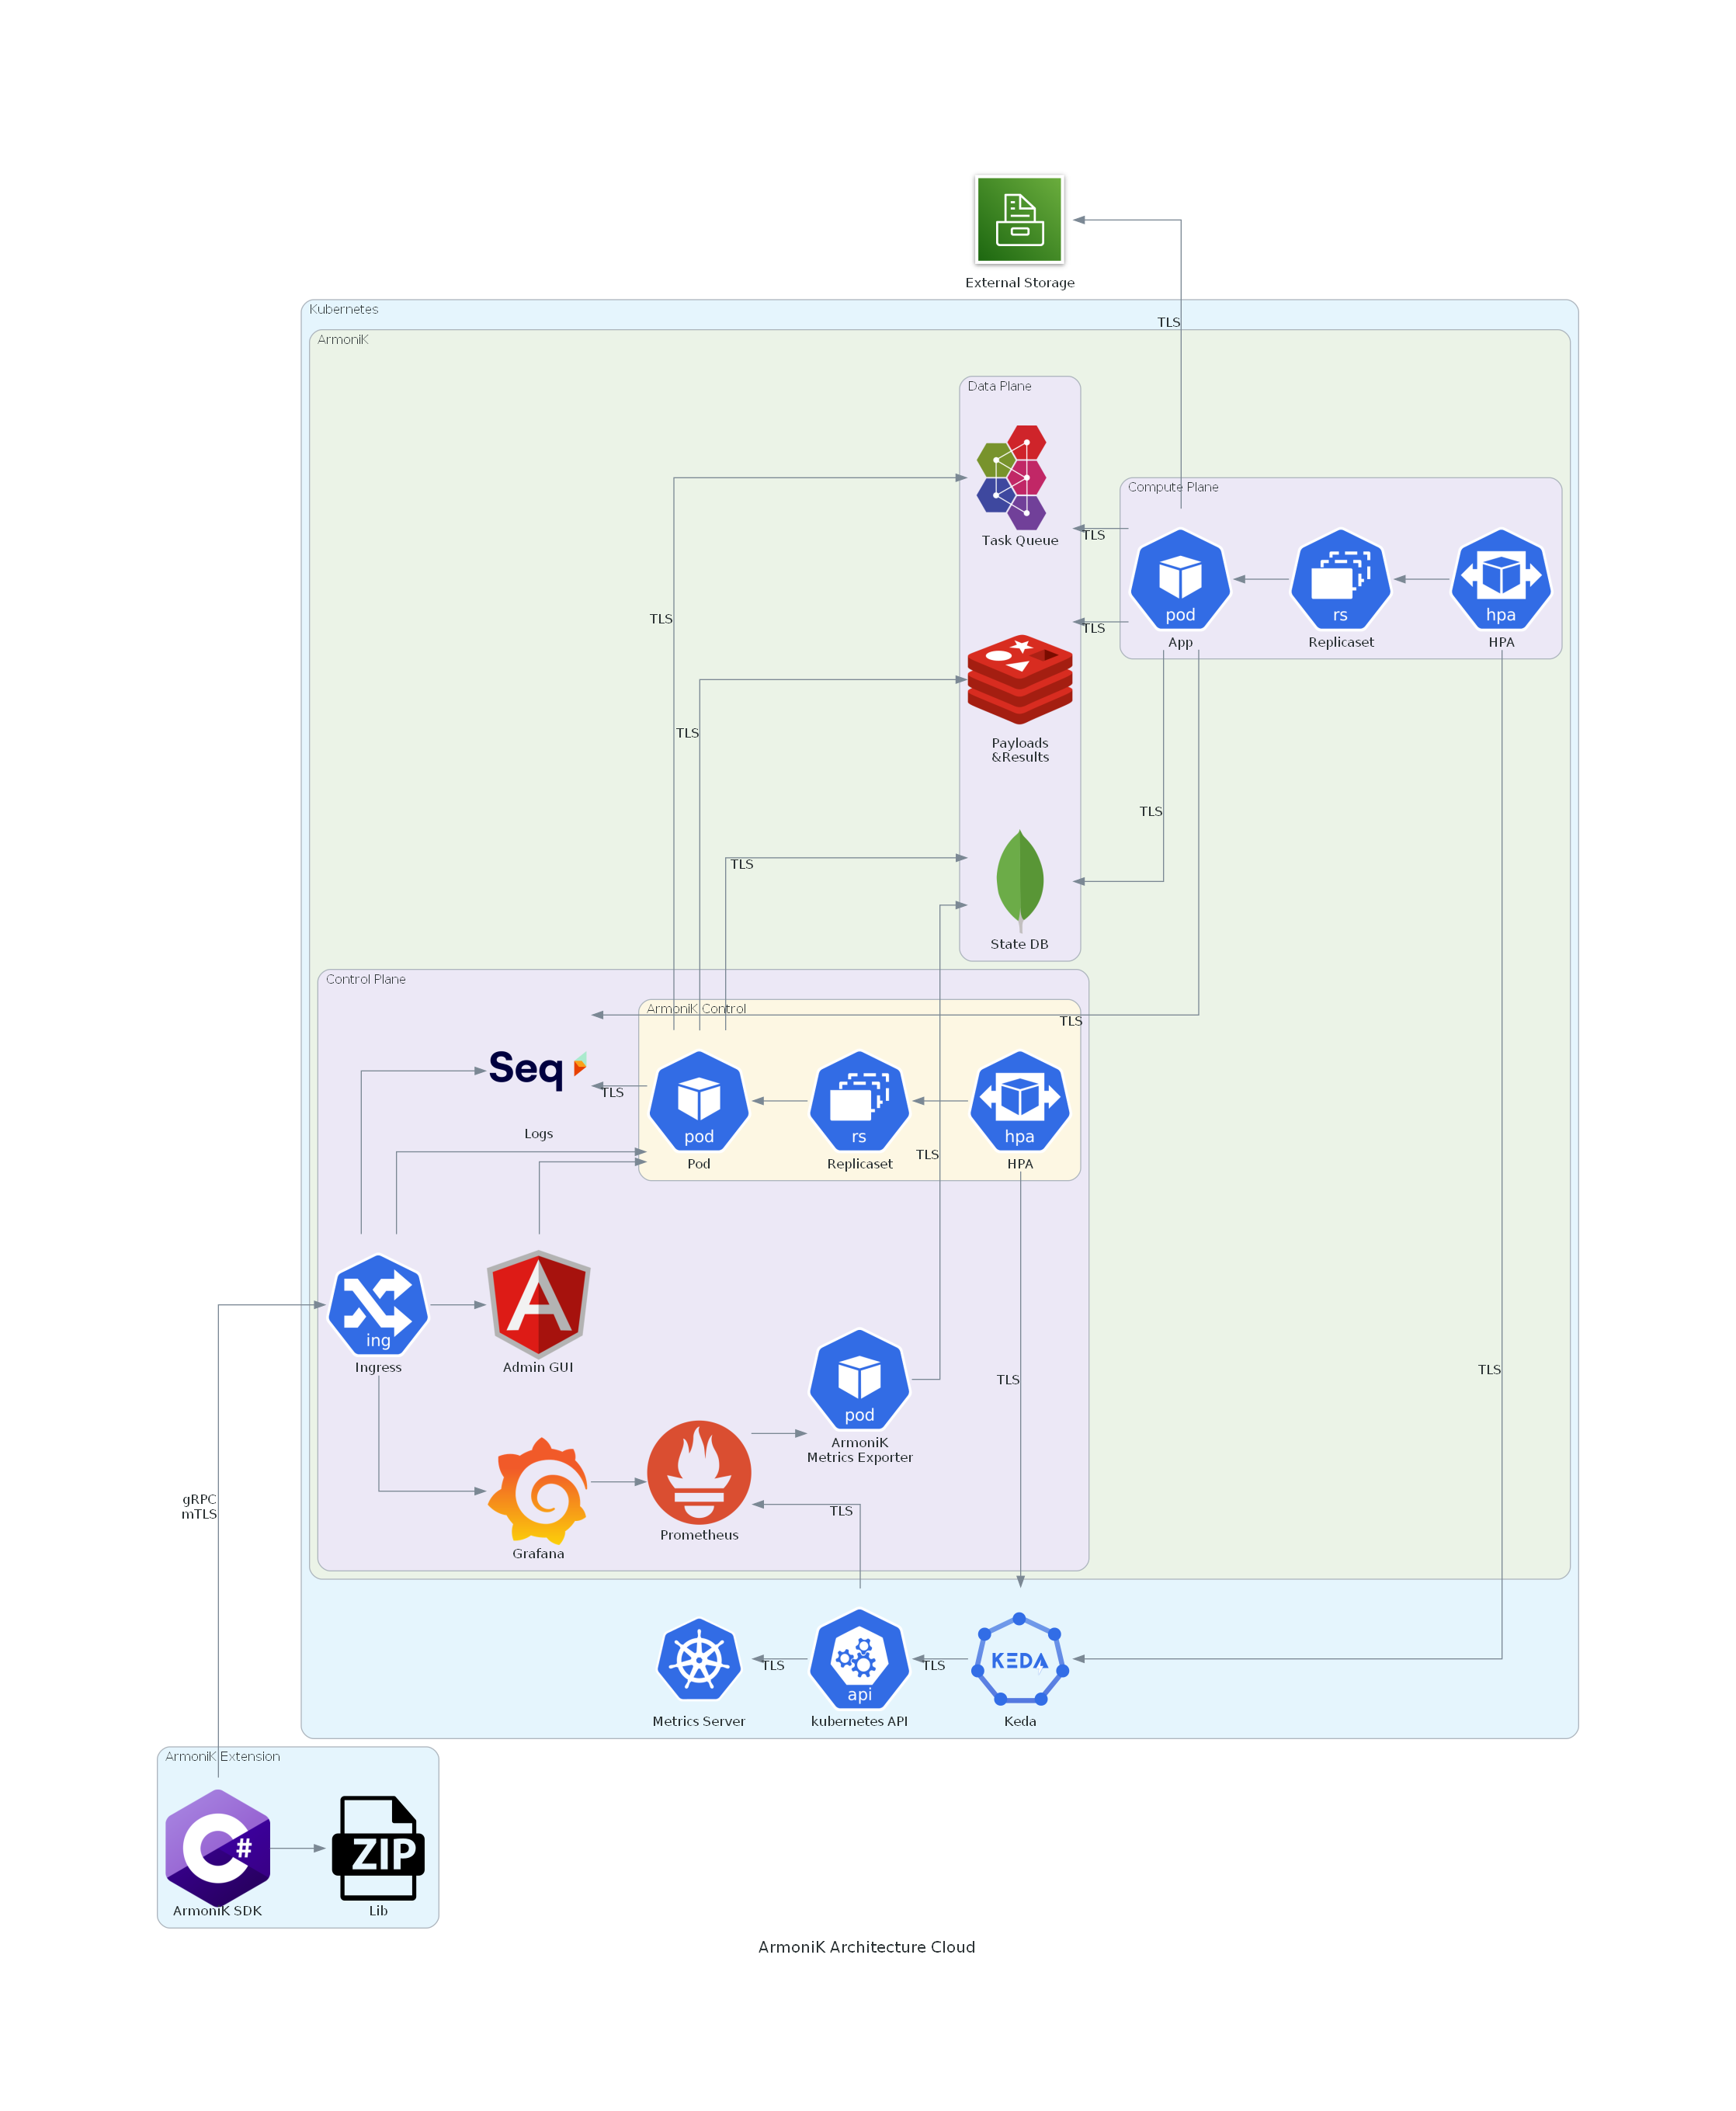

In [4]:
with Diagram("ArmoniK Architecture Cloud", show=False,  outformat="png", graph_attr=graph_attr) as diag:
 
    with Cluster("Kubernetes"):
        keda = Custom("Keda", keda_icon)
        kube_api = API("kubernetes API")        
        metrics_server = Custom("Metrics Server", metrics_server_icon)

        with Cluster("ArmoniK"):
            
            with Cluster("Data Plane"):
                    inner_storage = Inmem_storage("Payloads\n&Results")
                    task_queue = Queue("Task Queue")    
                    state_db = State_db("State DB")
            
            with Cluster("Control Plane"):
                metrics_viz = Grafana("Grafana")
                time_series_db = Prometheus("Prometheus")
                admin_gui = Angular("Admin GUI")
                metrics = Pod("ArmoniK\nMetrics Exporter")
                middleware = [metrics]

                ingress = Ingress("Ingress")
                
                with Cluster("ArmoniK Control"):
                    hpa_replicaset_sub = HPA("HPA")
                    replicaset_sub = ReplicaSet("Replicaset")
                    submitter = Pod("Pod")
                
                logs =  Custom("Logs", seq_icon)

            with Cluster("Compute Plane"):
                hpa_replicaset = HPA("HPA")
                replicaset = ReplicaSet("Replicaset")
                pod_compute = Pod("App")
    
    with Cluster("ArmoniK Extension"):
            app = Custom("Lib", zip_icon)
            sdk = Armonik_Extension("ArmoniK SDK")

    bucket = Bucket("External Storage")
    
    submitter  << replicaset_sub << hpa_replicaset_sub    
    pod_compute  << replicaset << hpa_replicaset
    #pod_compute >>  Edge(xlabel="TLS") >> bucket
    bucket << Edge(xlabel="TLS") << pod_compute 
                
    ingress >> [submitter, admin_gui, logs, metrics_viz]

    metrics_viz >> time_series_db
    admin_gui >> submitter
    #admin_gui >> Edge(xlabel="TLS") >> logs 
    submitter >>  Edge(xlabel="TLS") >> [inner_storage, 
                  task_queue, 
                  state_db]
    metrics >>  Edge(xlabel="TLS") >> state_db

    [inner_storage, 
     task_queue,
     state_db] << Edge(xlabel="TLS") << pod_compute     
     
    sdk >> app
    sdk >> Edge(xlabel="gRPC\nmTLS") >> [ingress]
    [sdk, pod_compute] >> Edge(xlabel="TLS") 
    
    logs << Edge(xlabel="TLS") << [pod_compute, submitter] 
    #hpa_replicaset >> Edge(xlabel="TLS") >> kube_api 
    keda << Edge(xlabel="TLS") << [hpa_replicaset, hpa_replicaset_sub] 
    
    
    kube_api << Edge(xlabel="TLS") << keda
    #keda >> Edge(label="TLS") >>  time_series_db >> metrics
     
    [time_series_db, metrics_server] << Edge(xlabel="TLS") << kube_api
    time_series_db >> metrics
    
diag

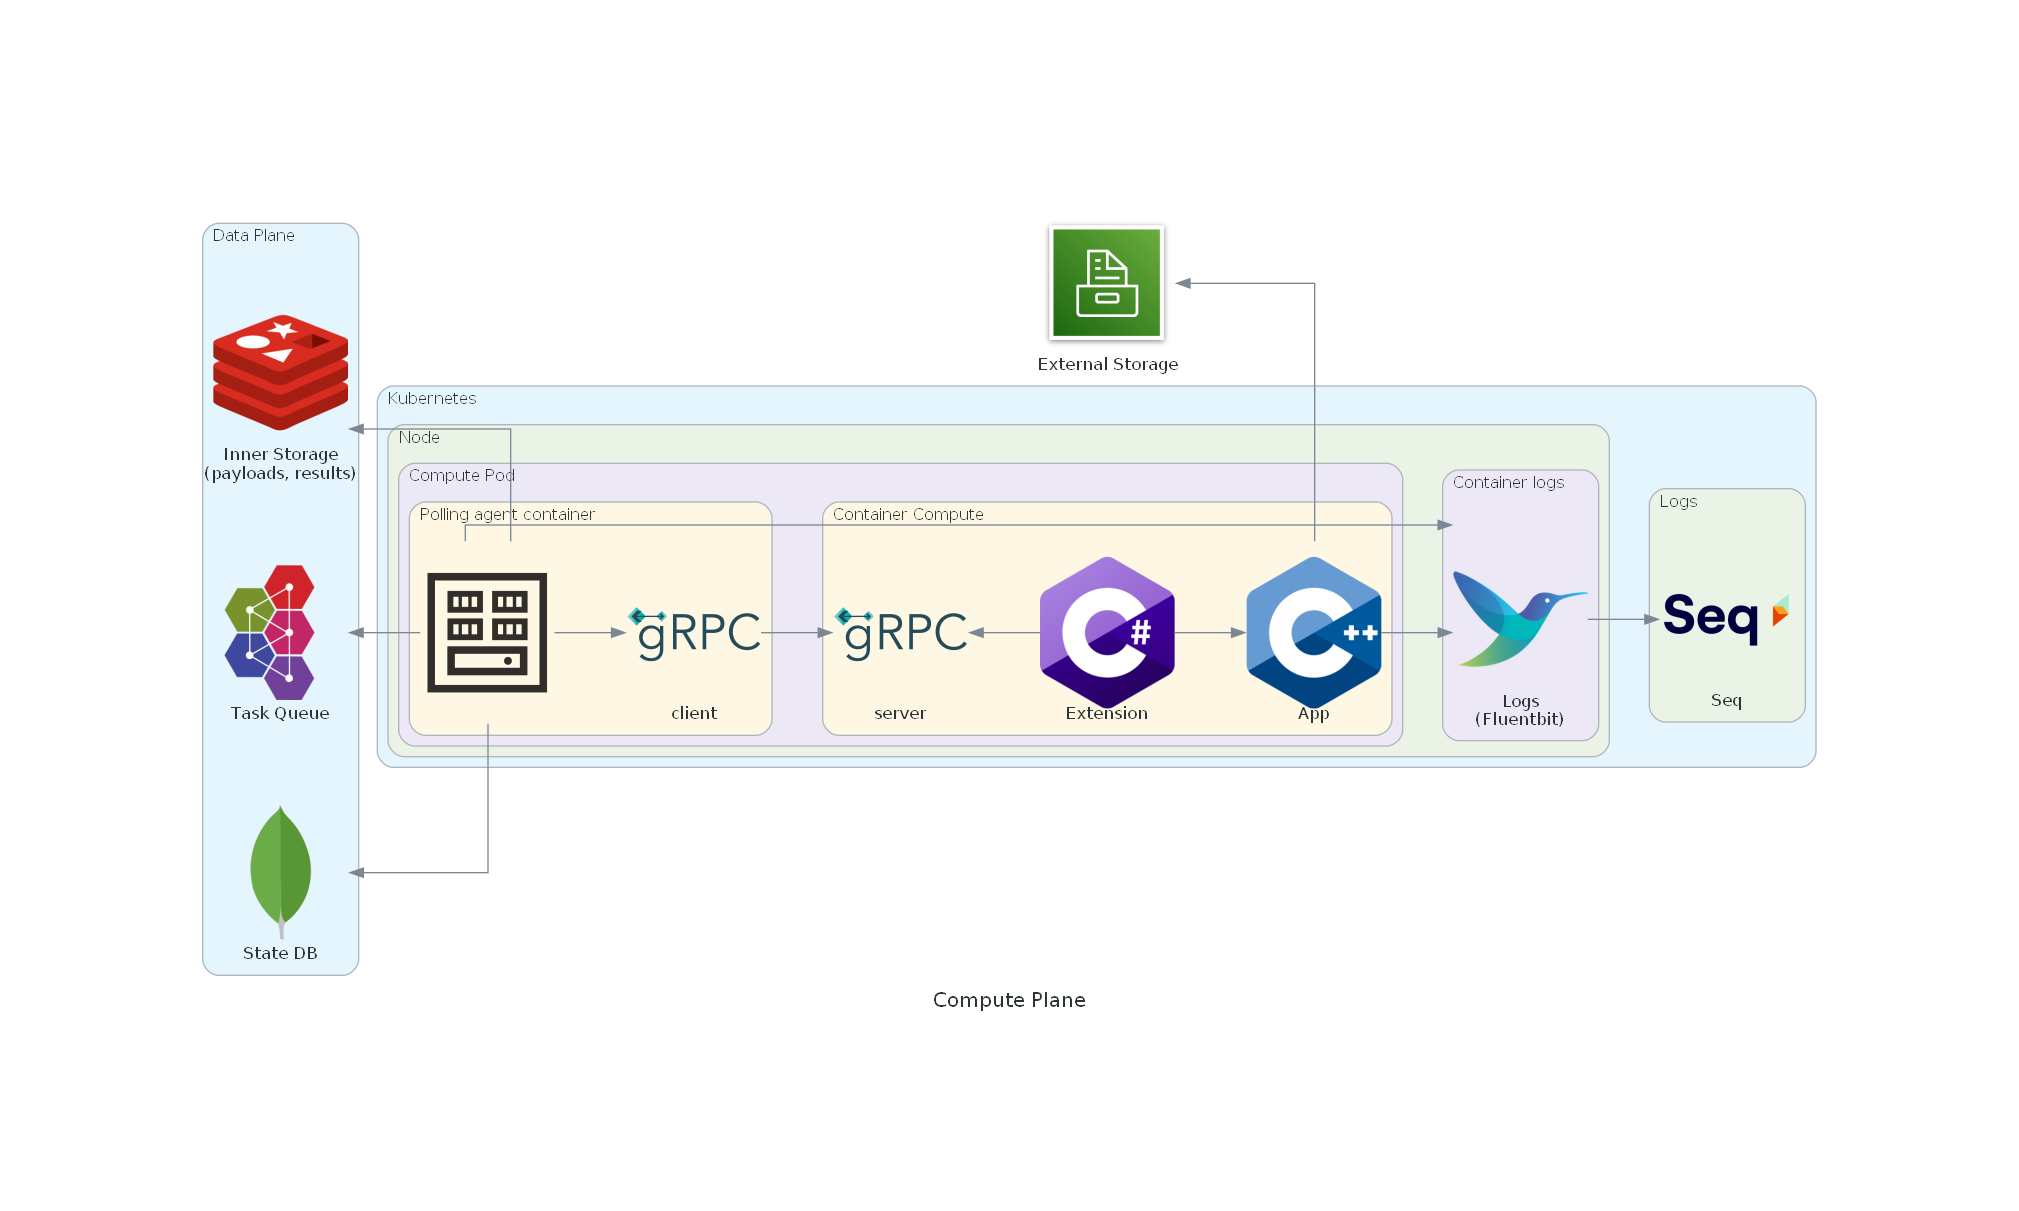

In [5]:
with Diagram("Compute Plane", show=False, outformat="png") as diag:
    
    bucket = Bucket("External Storage")
    
    with Cluster("Kubernetes"):
        with Cluster("Logs"):
            logs =  Custom("Seq", seq_icon)
            
        with Cluster("Node"):
            with Cluster("Compute Pod"):
                with Cluster("Polling agent container"):
                    polling_agent = Container("")
                    grpc_polling = Custom("client", grpc_icon)

                with Cluster("Container Compute"):
                    extension = Armonik_Extension("Extension")
                    grpc_compute = Custom("server", grpc_icon) 
                    app = Cpp("App")
            with Cluster("Container logs"):
                fluentbit = Fluentbit("Logs\n(Fluentbit)")
    
    with Cluster("Data Plane"):        
        inner_storage = Inmem_storage("Inner Storage\n(payloads, results)")
        task_queue = Queue("Task Queue")    
        state_db = State_db("State DB")
          
    polling_agent >> grpc_polling >> grpc_compute

    grpc_compute << extension >> app 
    [polling_agent, app] >> fluentbit >> logs
    bucket << app 
    [inner_storage, state_db, task_queue] << polling_agent
    #logs << [fluentbit, inner_storage, task_queue, state_db]
diag

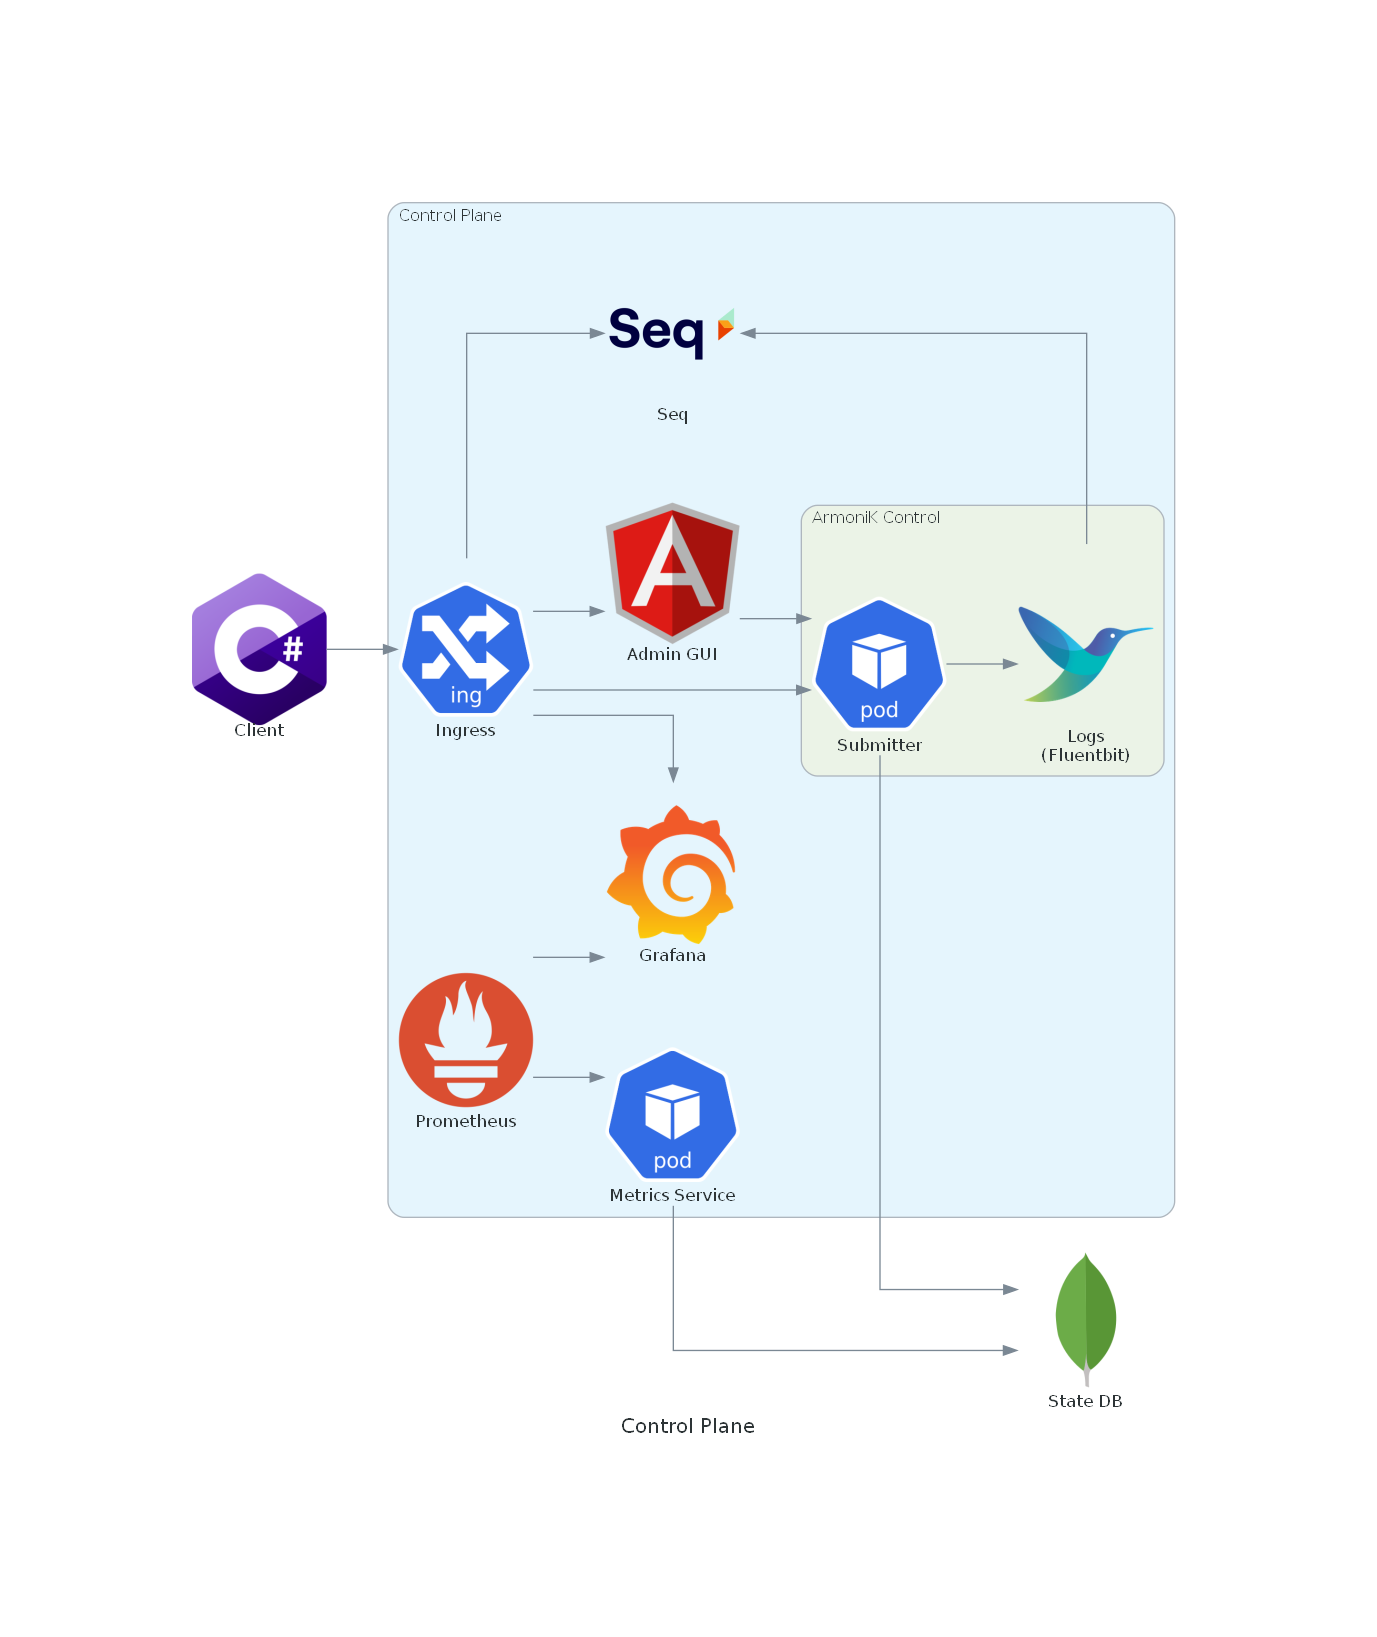

In [6]:
with Diagram("Control Plane", show=False, outformat="png") as diag:
    
    #with Cluster("Kubernetes"):
        #with Cluster("Data Plane"):
        #    task_queue = Queue("Task Queue")
        #    inner_storage = Inmem_storage("Payloads\nResults")
        #    state_db = State_db("State DB")

    state_db = State_db("State DB")
    client = Csharp("Client")
    with Cluster("Control Plane"):

        time_series_db = Prometheus("Prometheus")
        logs =  Custom("Seq", seq_icon)
        metrics_viz = Grafana("Grafana")

        admin_gui = Angular("Admin GUI")
        metrics = Pod("Metrics Service")
        #middleware = [submitter, metrics]
        ingress = Ingress("Ingress")

        with Cluster("ArmoniK Control"):
            submitter = Pod("Submitter")
            fluentbit = Fluentbit("Logs\n(Fluentbit)")

    ingress >> [submitter, admin_gui, logs, metrics_viz]

    time_series_db >> metrics_viz
    admin_gui >> [submitter]
    submitter >> state_db
    #submitter >> [inner_storage, 
    #              task_queue, 
    #              state_db]
    #metrics >> state_db     
    submitter >> fluentbit
    
    time_series_db >> metrics 
    state_db << metrics
    logs << fluentbit 
    #admin_gui >> logs
    client >> ingress
    

diag

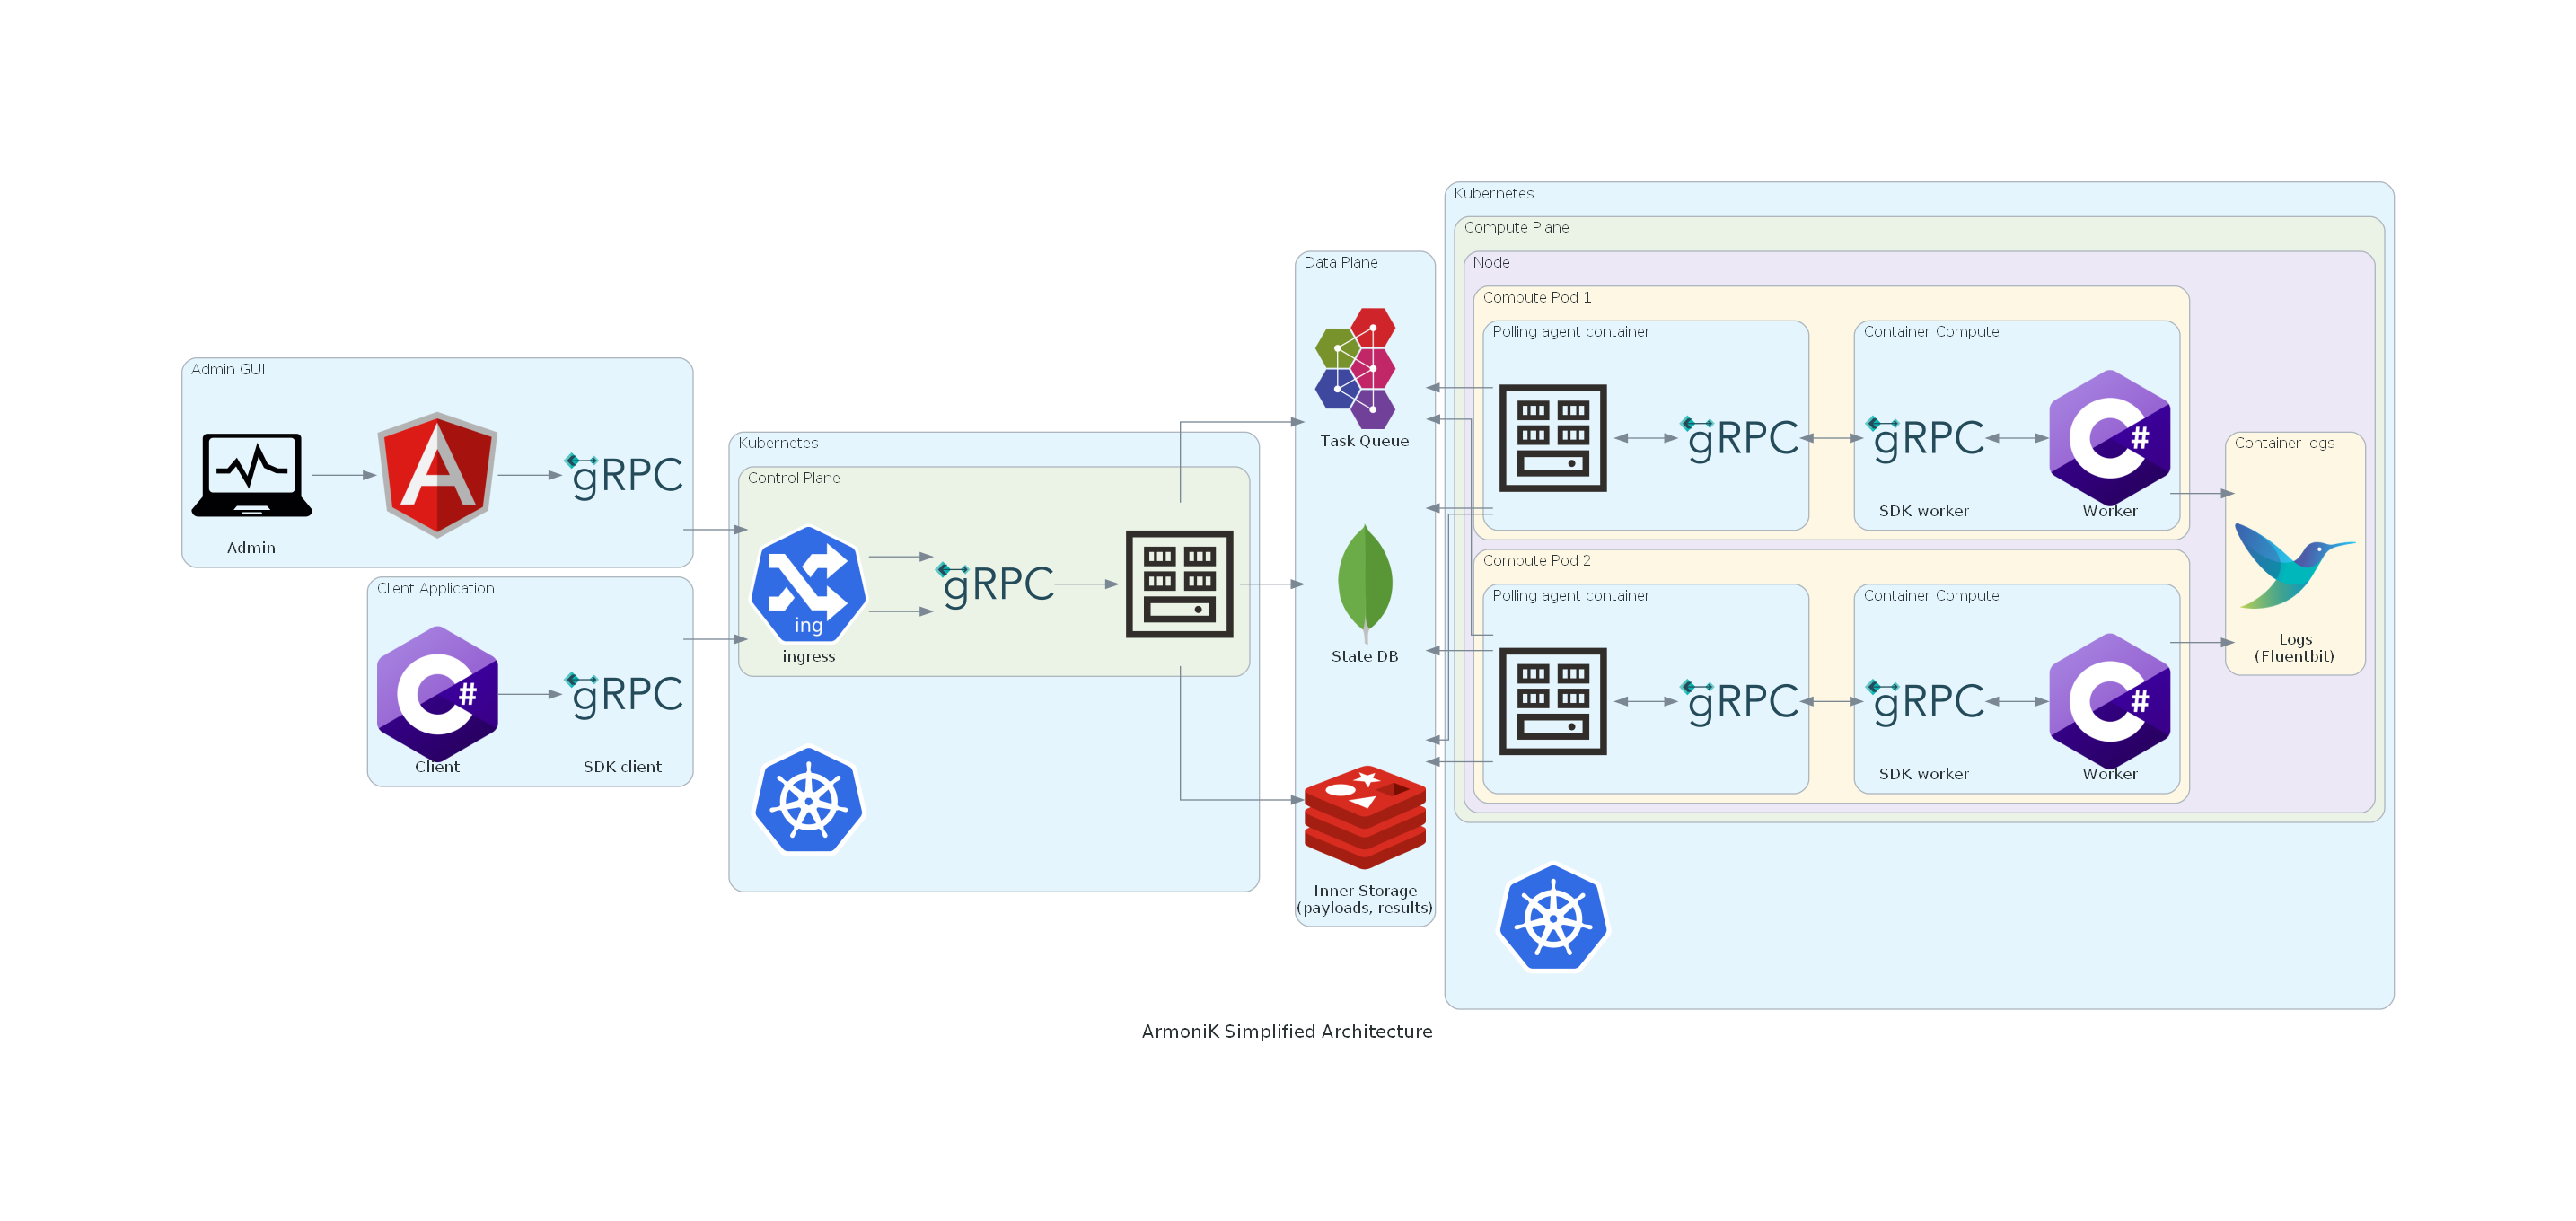

In [8]:
with Diagram("ArmoniK Simplified Architecture", show=False, outformat="svg") as diag:
        
    with Cluster("Admin GUI"):
        computer_client = Custom("Admin", computer_icon)
        admin_gui = Angular("")
        grpc_gui = Custom("", grpc_icon)
    
    with Cluster("Client Application"):
        client = Csharp("Client")
        grpc_client = Custom("SDK client", grpc_icon)
    
    with Cluster("Kubernetes"):
        kube_control = Custom("", kube_icon)
        with Cluster("Control Plane"):
            ingress = Ingress("ingress")
            grpc_submitter = Custom("", grpc_icon)        
            submitter = Container("")
    
    with Cluster("Kubernetes "):
        kube_control = Custom("", kube_icon)
        with Cluster("Compute Plane"):


            with Cluster("Node"):
                with Cluster("Compute Pod 1"):
                    with Cluster("Polling agent container"):
                        polling_agent2 = Container("")
                        grpc_polling2 = Custom("", grpc_icon)

                    with Cluster("Container Compute"):
                        extension2 = Armonik_Extension("Worker")
                        grpc_compute2 = Custom("SDK worker", grpc_icon) 

                with Cluster("Compute Pod 2"):
                    with Cluster("Polling agent container"):
                        polling_agent = Container("")
                        grpc_polling = Custom("", grpc_icon)

                    with Cluster("Container Compute"):
                        extension = Armonik_Extension("Worker")
                        grpc_compute = Custom("SDK worker", grpc_icon) 

                with Cluster("Container logs"):
                    fluentbit = Fluentbit("Logs\n(Fluentbit)")
    
    with Cluster("Data Plane"):
        state_db = State_db("State DB")
        inner_storage = Inmem_storage("Inner Storage\n(payloads, results)")
        task_queue = Queue("Task Queue")    
              
    polling_agent << Edge() >> grpc_polling << Edge() >> grpc_compute << Edge() >> extension >> fluentbit 
    polling_agent2 << Edge() >> grpc_polling2 << Edge() >> grpc_compute2 << Edge() >> extension2 >> fluentbit

    [state_db, inner_storage, task_queue] << polling_agent
    [state_db, inner_storage, task_queue] << polling_agent2
    
    
    client >> grpc_client >> ingress >> grpc_submitter >> submitter >> [inner_storage, state_db, task_queue]
    
    computer_client >> admin_gui >> grpc_gui >> ingress >> grpc_submitter
    
diag